In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150
pd.options.mode.chained_assignment = None  # default='warn'

## Importation des csv

In [255]:
df_olist_customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")
df_olist_order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")
df_olist_order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
df_olist_order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_olist_orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")
df_olist_products_dataset = pd.read_csv("data/olist_products_dataset.csv")
df_olist_sellers_dataset = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")

df_olist_geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")

Dans le dataset des reviews on transforme la colonne review_comment_title et review_comment_message pour obtenir la longueur du message et du titre

In [256]:
from functions import *

df_olist_order_reviews_dataset['length_comment_title'] = df_olist_order_reviews_dataset["review_comment_title"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset['length_comment_message'] = df_olist_order_reviews_dataset["review_comment_message"].apply(lambda x:length_str(x))

df_olist_order_reviews_dataset.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)

df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.groupby(["order_id","review_score"]).agg({"length_comment_title":"max","length_comment_message":"max","review_answer_timestamp":"first"})
df_olist_order_reviews_dataset.reset_index(inplace=True)

In [257]:
# Convertir la colonne 'date' en un objet de type datetime
df_olist_order_reviews_dataset['review_answer_timestamp'] = pd.to_datetime(df_olist_order_reviews_dataset['review_answer_timestamp'])

# Groupby order_id et trouver l'index de la date la plus récente pour chaque order_id
latest_dates = df_olist_order_reviews_dataset.groupby('order_id').review_answer_timestamp.idxmax()

# Utilisez l'index trouvé pour sélectionner les lignes avec les dates les plus récentes
df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.loc[latest_dates]

Dans le dataset des produits on remplace les nan de la colonne product_photos_qty par 0.

On remplace les nan de la colonne product_category_name par unknown.

On remplace les nan de la colonne product_description_lenght par 0.

On drop la colonne product_name_lenght.

In [258]:
df_olist_products_dataset["product_photos_qty"].fillna(0,inplace=True)
df_olist_products_dataset["product_photos_qty"] = df_olist_products_dataset["product_photos_qty"].astype('int8')
df_olist_products_dataset["product_category_name"].fillna("unknown",inplace=True)
df_olist_products_dataset["product_description_lenght"].fillna(0,inplace=True)
df_olist_products_dataset.drop("product_name_lenght",axis=1,inplace=True)


In [259]:
df_product = df_olist_products_dataset.merge(df_product_category_name_translation,how="outer",on="product_category_name")
df_product["product_category_name_english"].fillna("unknown",inplace=True)
df_product.drop("product_category_name",axis=1,inplace=True)

In [260]:
category_mapping = {
"Agro_Industry_and_Commerce": ["agro_industry_and_commerce", "industry_commerce_and_business"],
"Home_and_Comfort": ["air_conditioning", "home_appliances", "home_appliances_2", "home_comfort_2", "home_confort", "housewares", "la_cuisine", "small_appliances", "small_appliances_home_oven_and_coffee","security_and_services", "signaling_and_security"],
"Audio_and_Visual": ["audio", "cds_dvds_musicals", "cine_photo", "dvds_blu_ray", "music", "musical_instruments", "tablets_printing_image"],
"Automotive": ["auto"],
"Baby": ["baby", "diapers_and_hygiene"],
"Food_and_drinks": ["drinks", "food", "food_drink"],
"Computers_and_Electonics": ["computers", "computers_accessories", "electronics"],
"Construction": ["construction_tools_construction", "construction_tools_lights", "construction_tools_safety", "costruction_tools_garden", "costruction_tools_tools", "home_construction"],
"Well-being": ["art", "arts_and_craftmanship","flowers", "party_supplies", "toys", "cool_stuff", "christmas_supplies", "pet_shop", "consoles_games", "luggage_accessories", "watches_gifts", "garden_tools", "books_general_interest", "books_imported", "books_technical"],
"Health_and_Beauty": ["health_beauty","perfumery"],
"Fashion": ["fashio_female_clothing", "fashion_bags_accessories", "fashion_childrens_clothes", "fashion_male_clothing", "fashion_shoes", "fashion_underwear_beach"],
"Sport": ["sports_leisure", "fashion_sport"],
"Miscellaneous": ["market_place", "stationery", "unknown"],
"Communication": ["telephony", "fixed_telephony"],
"Furniture": ["bed_bath_table","furniture_decor", "office_furniture","furniture_bedroom", "furniture_living_room", "furniture_mattress_and_upholstery","kitchen_dining_laundry_garden_furniture"]
}

def reverse_dict(d):
    rev_dict = {}
    for key, value in d.items():
        for val in value:
            rev_dict[val] = key
    return rev_dict

reversed_mapping = reverse_dict(category_mapping)


On regarde le montant total pour chaque categorie

In [261]:
df_categorie = df_olist_orders_dataset.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_categorie = df_categorie.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_categorie = df_categorie.merge(df_product,how="outer",on='product_id')

In [262]:
df_categorie = df_categorie.loc[df_categorie['order_status'] == "delivered"]

In [263]:
df_categorie = df_categorie.groupby("product_category_name_english").agg({"price":"sum","freight_value":"sum","order_item_id":"count"}).reset_index()

In [264]:
df_categorie["montant_total"]=df_categorie["price"] + df_categorie["freight_value"]

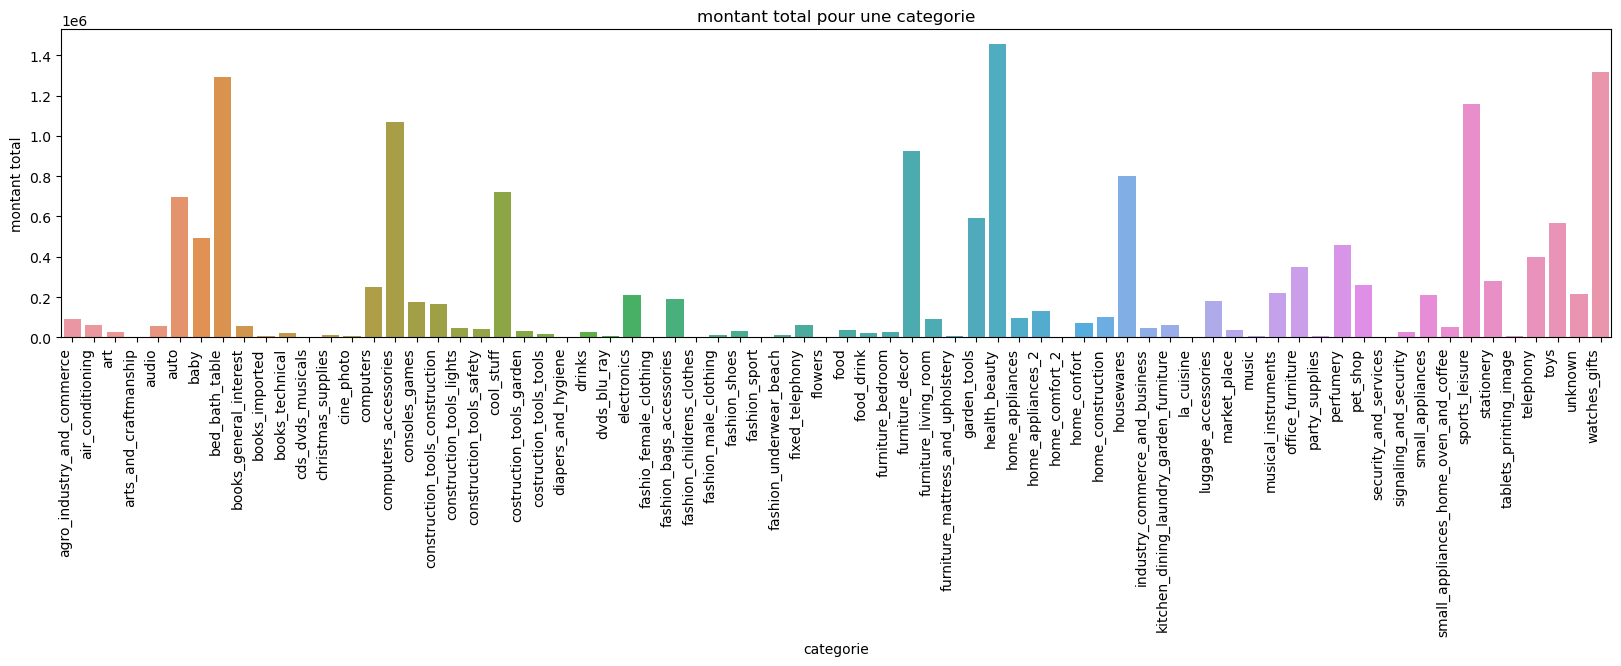

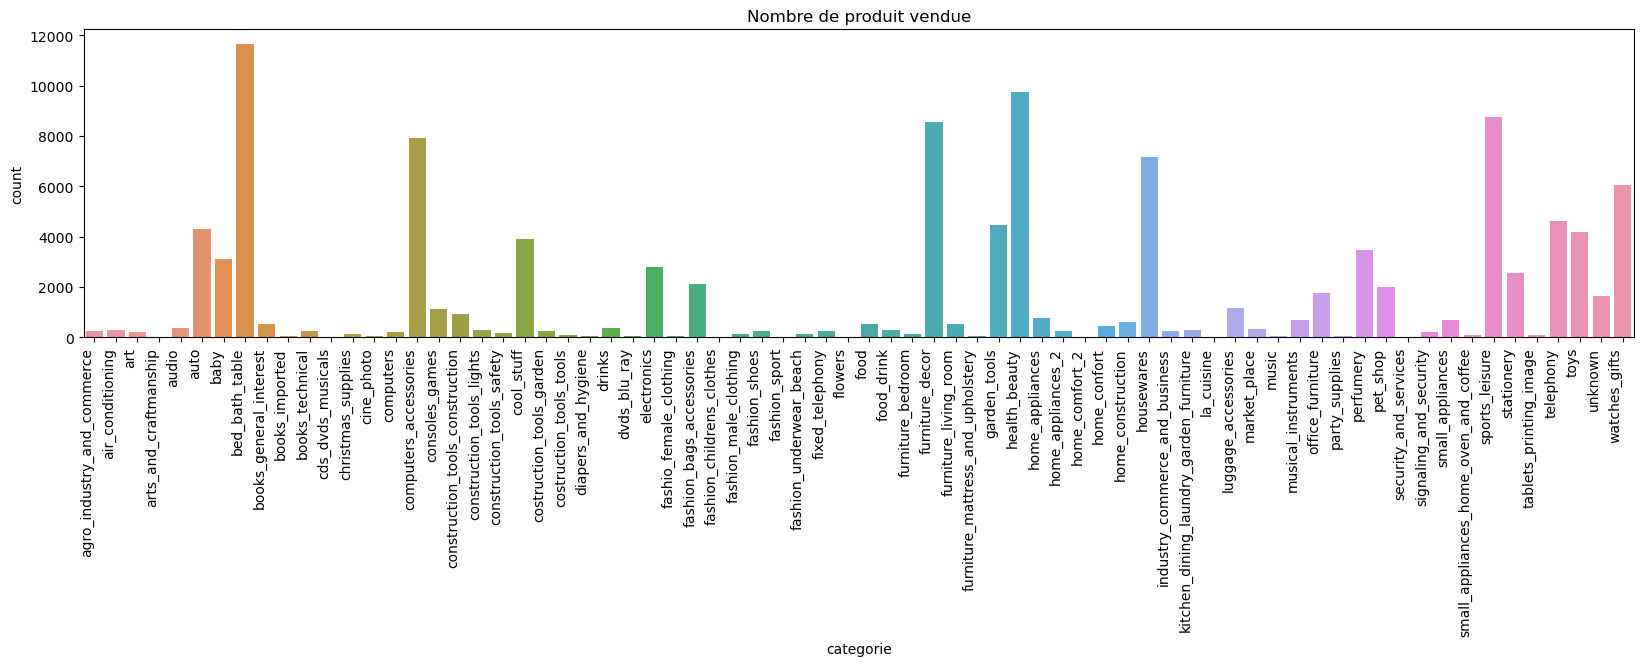

In [265]:
fig, ax = plt.subplots(figsize=(20, 4))

# Premier histogramme
sns.barplot(data = df_categorie , x="product_category_name_english",y="montant_total",ax=ax)
ax.set_title(f"montant total pour une categorie")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("montant total")

plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
# Affichage de la figure
sns.barplot(data = df_categorie , x="product_category_name_english",y="order_item_id",ax=ax)
ax.set_title(f"Nombre de produit vendue")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("count")

plt.show()

In [266]:
df_categorie["product_category_name_english"] = df_categorie["product_category_name_english"].map(reversed_mapping)

In [267]:
df_categorie = df_categorie.groupby("product_category_name_english").agg({"montant_total":"sum","order_item_id":"sum"}).reset_index()

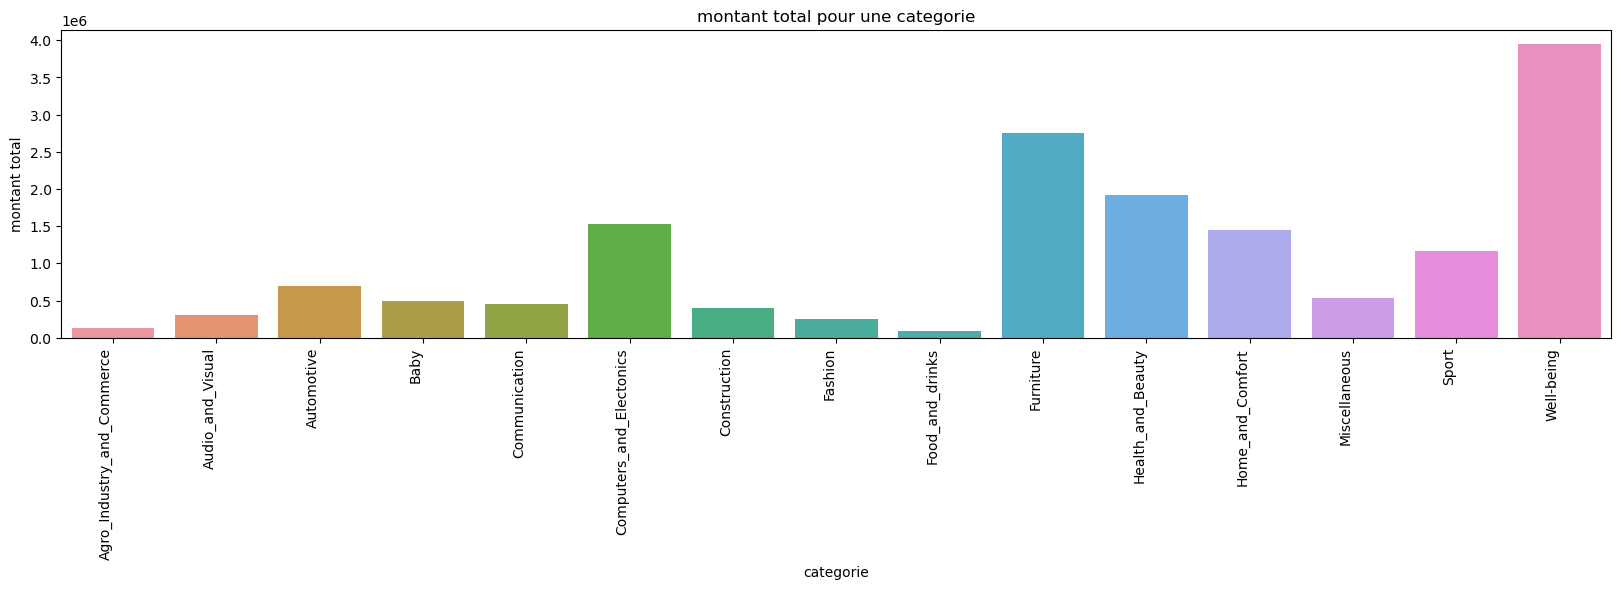

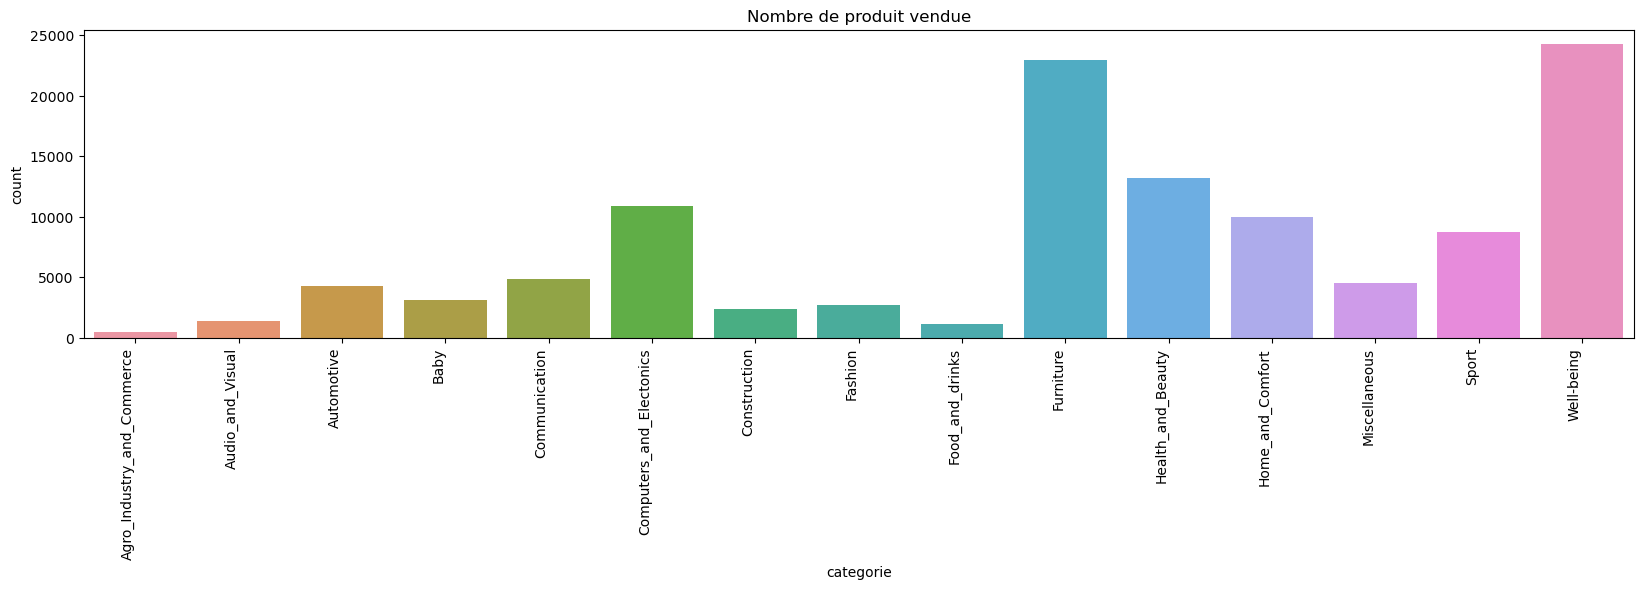

In [268]:
fig, ax = plt.subplots(figsize=(20, 4))

# Premier histogramme
sns.barplot(data = df_categorie , x="product_category_name_english",y="montant_total",ax=ax)
ax.set_title(f"montant total pour une categorie")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("montant total")

plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
# Affichage de la figure
sns.barplot(data = df_categorie , x="product_category_name_english",y="order_item_id",ax=ax)
ax.set_title(f"Nombre de produit vendue")
ax.set_xlabel("categorie")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='right')
ax.set_ylabel("count")

plt.show()

In [269]:
df_product["product_category_name_english"] = df_product["product_category_name_english"].map(reversed_mapping)

Dans le dataset des items on groupe par la colonne order_id . Pour obtenir le produit et le vendeur le plus frequent de la commande, le nombre de produit dans la commande et la somme des prix et cout de transport

In [270]:
def get_mode(x):
    return x.mode().iloc[0]
    
df_olist_order_items_dataset = df_olist_order_items_dataset.groupby(["order_id"]).agg({"product_id":get_mode,"seller_id":get_mode,"order_item_id":"count","price":"sum","freight_value":"sum"})
df_olist_order_items_dataset.columns=["product_most_frequent","most_frequent_seller",'nb_items', 'sum_price', 'sum_freight_value']
df_olist_order_items_dataset.reset_index(inplace=True)

Regroupement par order_id dans le dataset payments pour que les order_id soit unique

In [271]:
df_olist_order_payments_dataset = df_olist_order_payments_dataset.groupby(["order_id"]).agg({"payment_type":get_mode,"payment_sequential":"count","payment_installments":"max","payment_value":"sum"})
df_olist_order_payments_dataset.rename(columns={"payment_type":"payment_type_most_frequent"},inplace=True)
df_olist_order_payments_dataset.reset_index(inplace=True)

## Merge des datasets

In [272]:
df_merge = df_olist_orders_dataset.merge(df_olist_order_reviews_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_customers_dataset,how="outer",on="customer_id")
df_merge = df_merge.merge(df_product,how="left",right_on='product_id',left_on="product_most_frequent")
df_merge = df_merge.merge(df_olist_sellers_dataset,how="outer",left_on="most_frequent_seller",right_on="seller_id")

In [273]:
# Group the dataframe by zip code and aggregate by median latitude and median longitude
zip_code_lat_long = df_olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat': 'median', 'geolocation_lng': 'median'}).reset_index()
# Print the results
print(zip_code_lat_long)

       geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                             1001       -23.550381       -46.634027
1                             1002       -23.548551       -46.635072
2                             1003       -23.548977       -46.635313
3                             1004       -23.549535       -46.634771
4                             1005       -23.549612       -46.636532
...                            ...              ...              ...
19010                        99960       -27.953797       -52.029641
19011                        99965       -28.179542       -52.035551
19012                        99970       -28.343273       -51.873734
19013                        99980       -28.388092       -51.846880
19014                        99990       -28.329595       -51.769362

[19015 rows x 3 columns]


In [274]:
import math

df_merge = df_merge.merge(zip_code_lat_long,how="left",left_on="customer_zip_code_prefix",right_on="geolocation_zip_code_prefix")
df_merge.rename(columns={"geolocation_lat":"customer_geolocation_lat","geolocation_lng":"customer_geolocation_lng"}, inplace=True)
df_merge.drop("geolocation_zip_code_prefix", axis=1,inplace=True)
df_merge = df_merge.merge(zip_code_lat_long,how="left",left_on="seller_zip_code_prefix",right_on="geolocation_zip_code_prefix")
df_merge.rename(columns={"geolocation_lat":"seller_geolocation_lat","geolocation_lng":"seller_geolocation_lng"}, inplace=True)
df_merge.drop("geolocation_zip_code_prefix", axis=1,inplace=True)

df_merge['distance'] = math.dist([df_merge.customer_geolocation_lat,df_merge.customer_geolocation_lng],[df_merge.seller_geolocation_lat,df_merge.seller_geolocation_lng])

# df_merge['distance'] = ((df_merge.customer_geolocation_lat - df_merge.seller_geolocation_lat)**2 + 
#                         (df_merge.customer_geolocation_lng - df_merge.seller_geolocation_lng)**2)**0.5

df_merge.drop(["customer_geolocation_lat","customer_geolocation_lng","seller_geolocation_lat","seller_geolocation_lng"], axis=1,inplace=True)

TypeError: cannot convert the series to <class 'float'>

In [ ]:
df_merge['distance']

0        0.177535
1        0.211073
2        1.125596
3        0.347321
4        7.748334
           ...   
99446         NaN
99447         NaN
99448         NaN
99449         NaN
99450         NaN
Name: distance, Length: 99451, dtype: float64

Visualisation des valeurs manquantes

<AxesSubplot: >

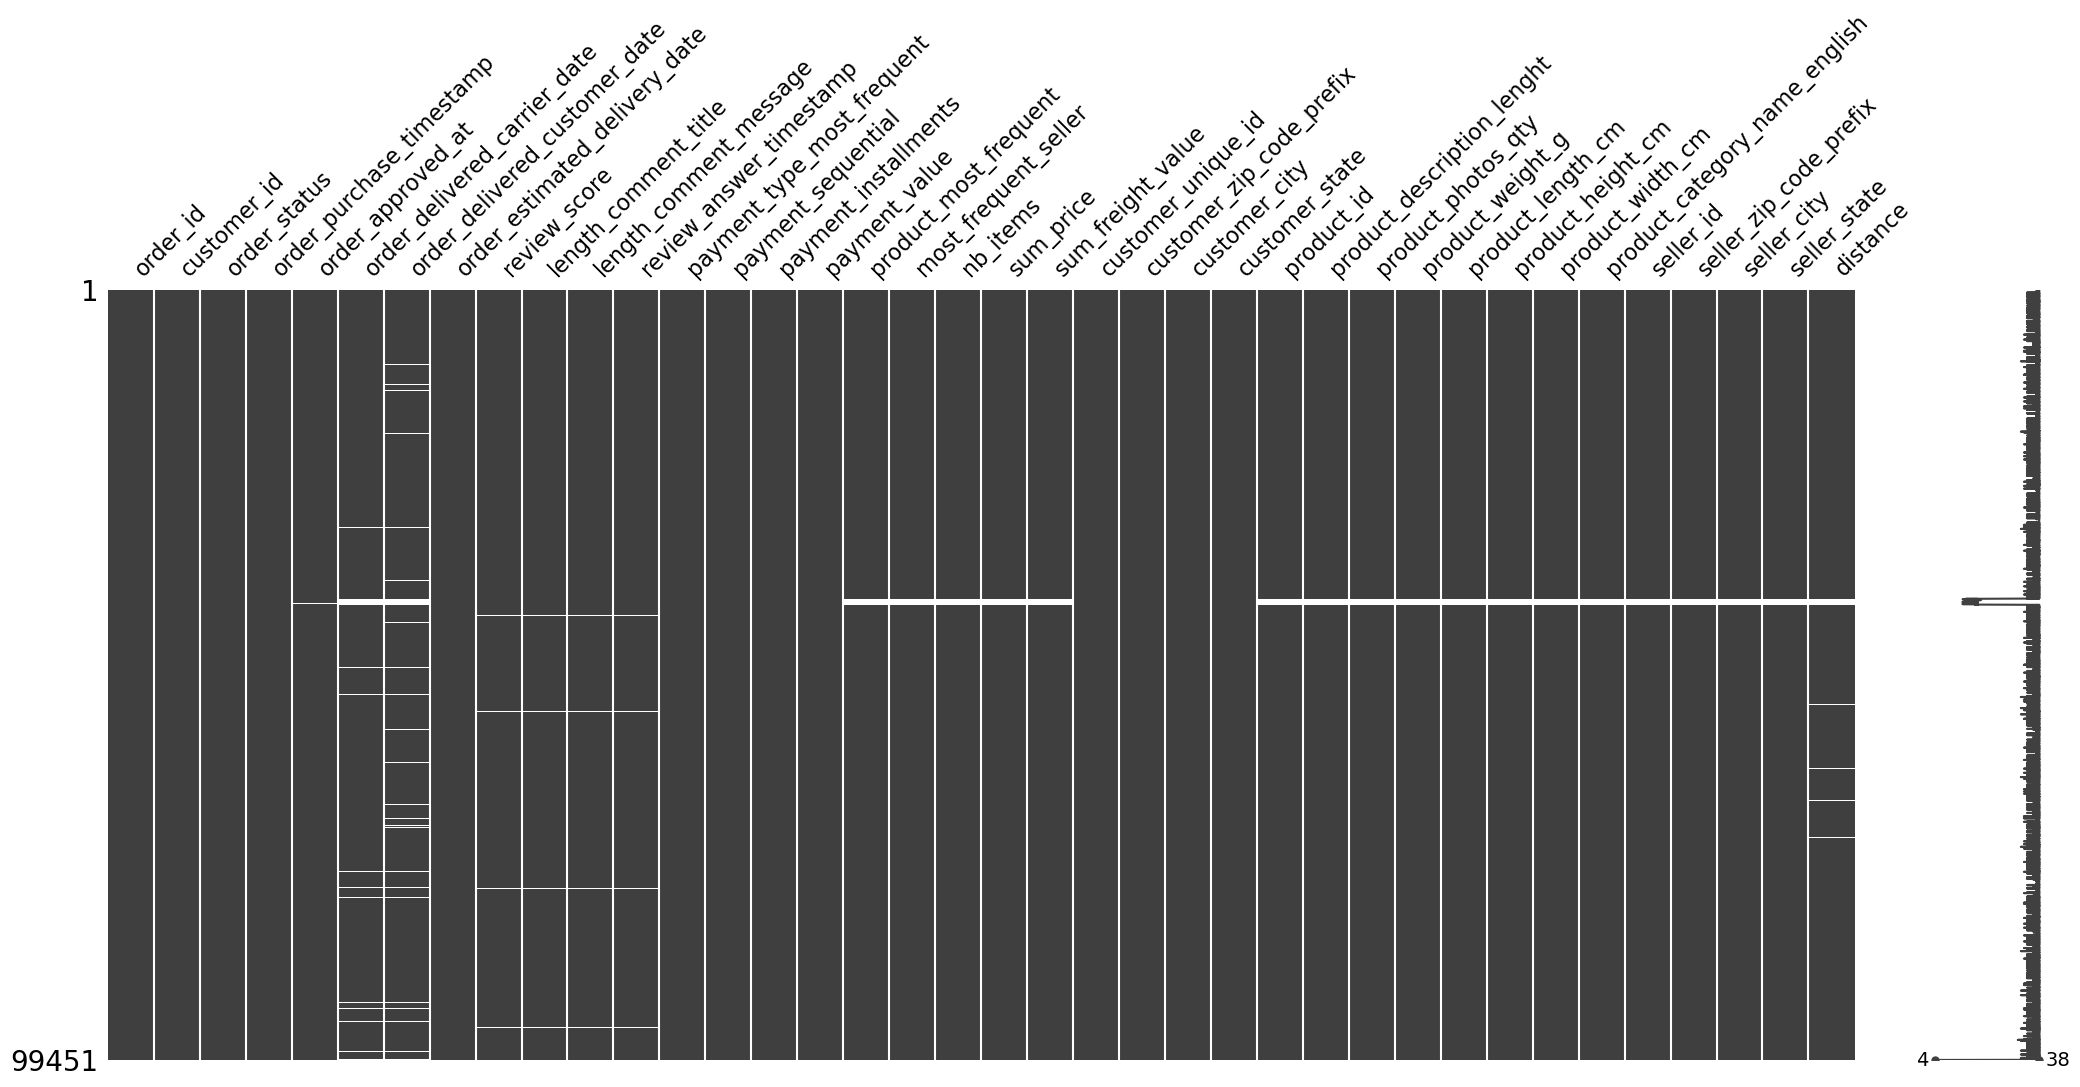

In [ ]:
stop
import missingno as msno

msno.matrix(df_merge)

In [ ]:
df_merge.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'length_comment_title', 'length_comment_message',
       'review_answer_timestamp', 'payment_type_most_frequent',
       'payment_sequential', 'payment_installments', 'payment_value',
       'product_most_frequent', 'most_frequent_seller', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_id', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'distance'],
      dtype='object')

In [ ]:
columns=["review_score","length_comment_title","length_comment_message","payment_installments","payment_value","nb_items","product_description_lenght","product_photos_qty"]

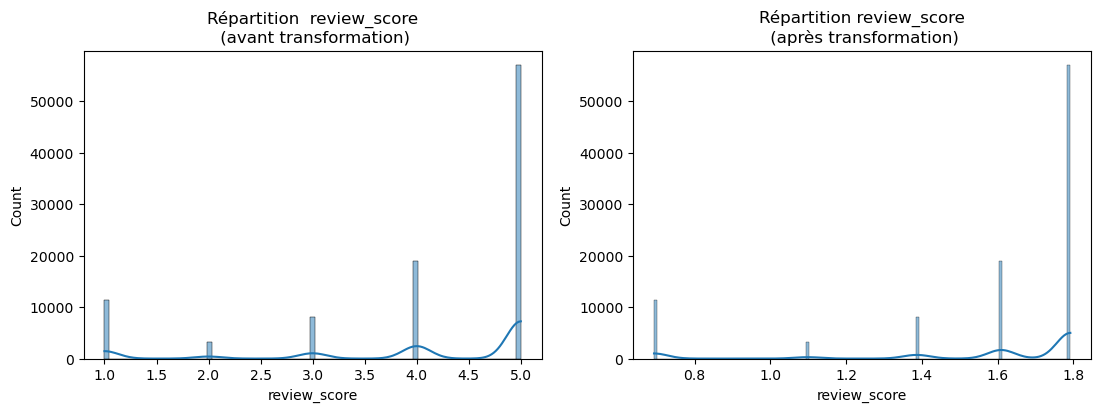

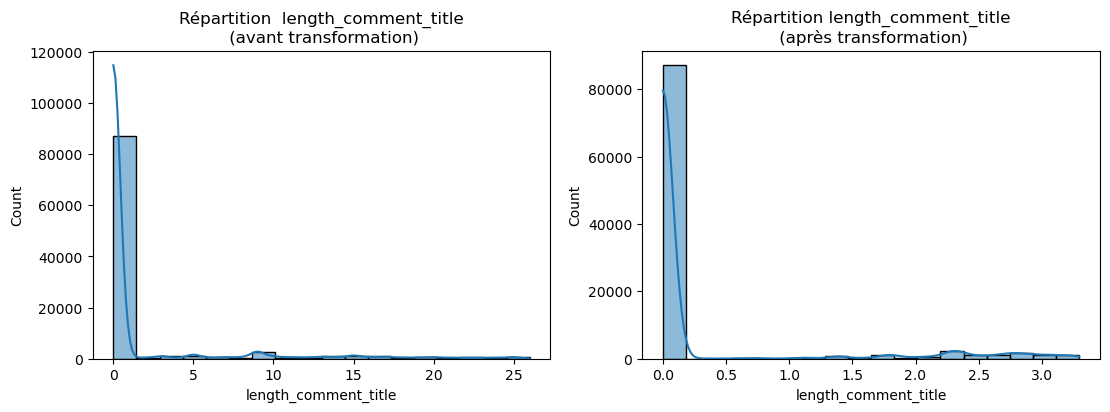

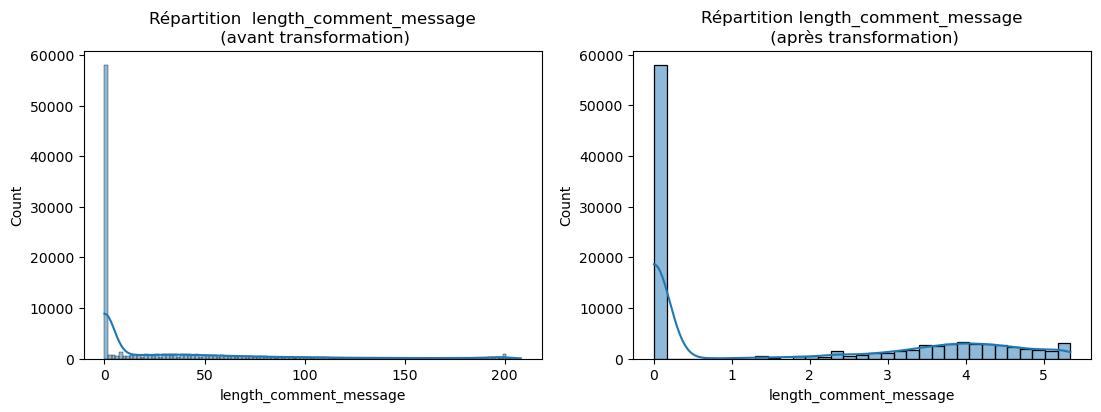

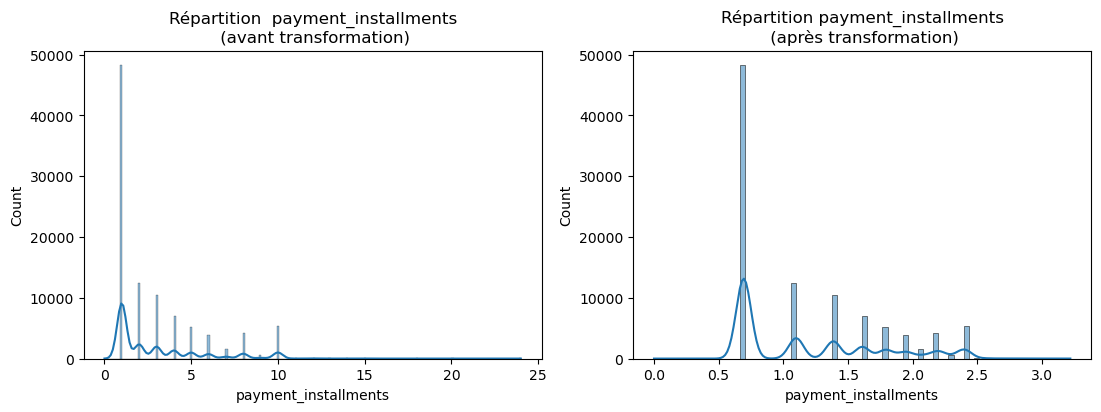

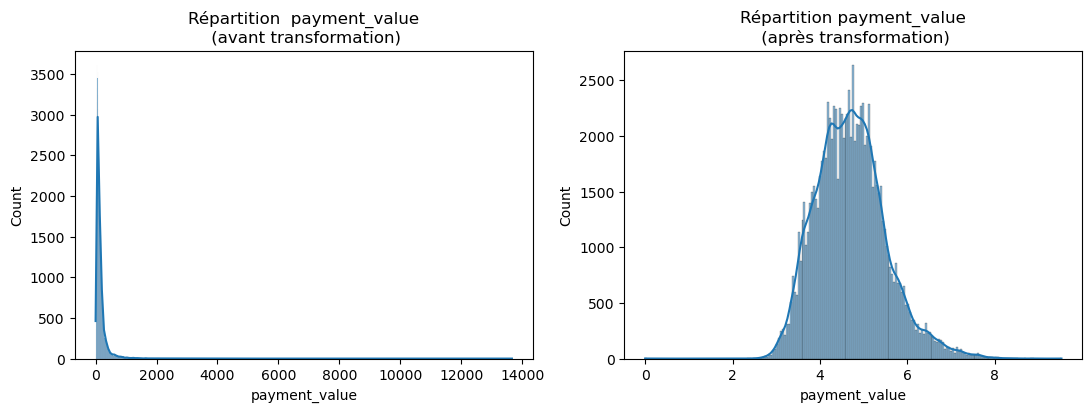

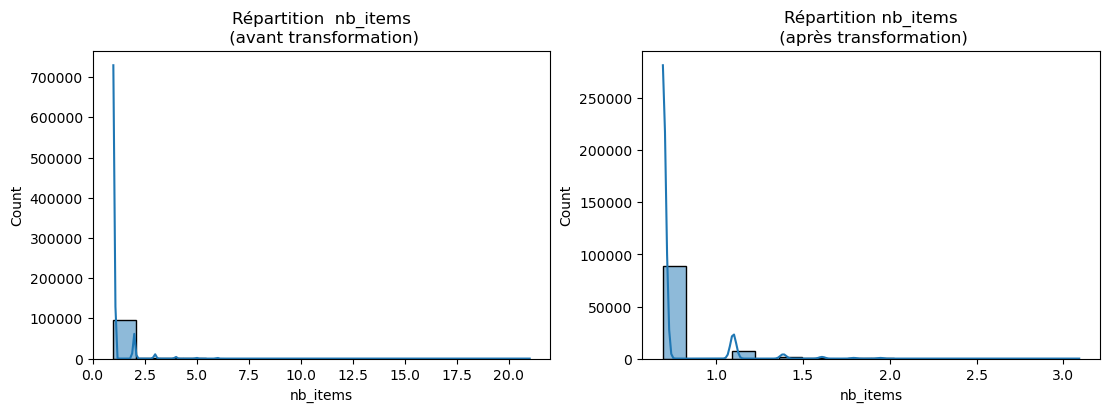

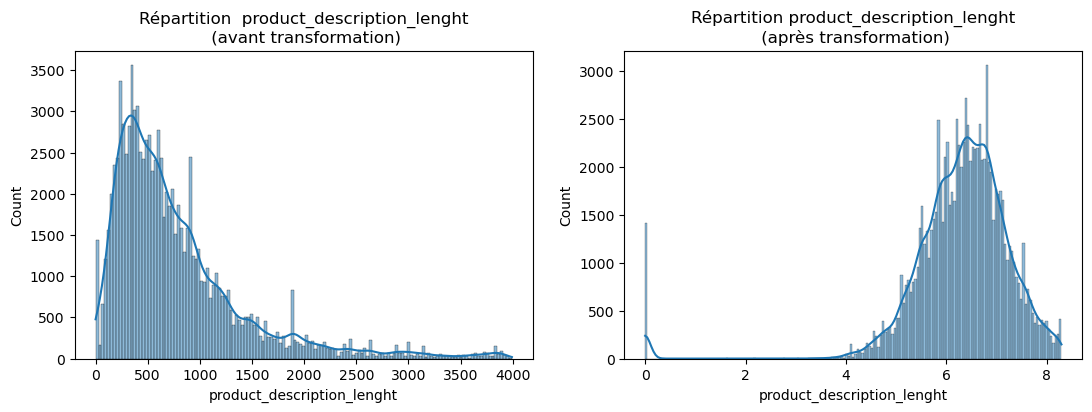

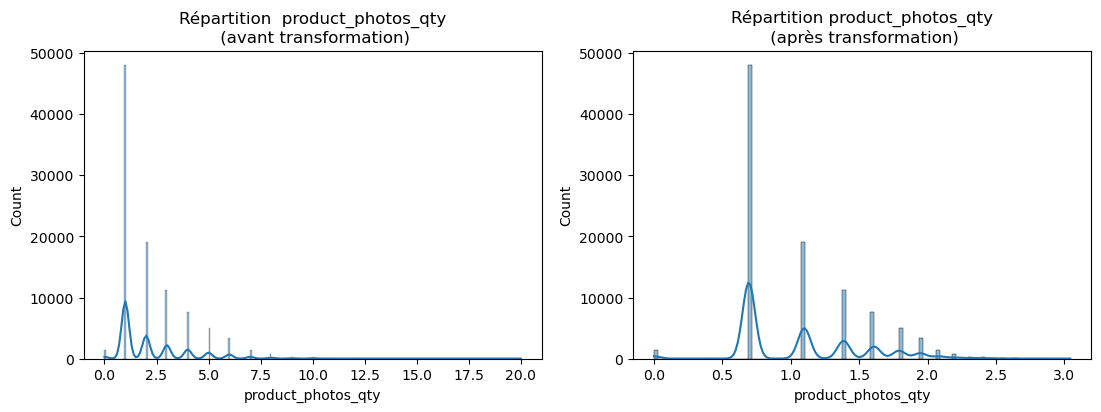

In [ ]:
df_log = np.log1p(df_merge[columns])

for col in columns:
    # Création de la figure et des subplots
    fig, ax = plt.subplots(1,2, figsize=(13, 4))

    # Premier histogramme
    sns.histplot(df_merge[col],ax=ax[0], kde=True)
    ax[0].set_title(f"Répartition  {col}\n (avant transformation)")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Count")

    # Second histogramme
    sns.histplot(df_log[col],ax=ax[1], kde=True)
    ax[1].set_title(f"Répartition {col}\n (après transformation)")
    ax[1].set_xlabel(col)
    ax[1].set_ylabel("Count")

    # Affichage de la figure
    plt.show()

In [ ]:
df_merge['order_status'].value_counts().to_frame()/len(df_merge)*100

,order_status
delivered,97.010588
shipped,1.113111
canceled,0.628450
unavailable,0.612362
invoiced,0.315733
processing,0.302662
created,0.005028
approved,0.002011


Nous ne conserverons que les order_statuts qui sont "delivered" car les autres catégories sont trop peu représentées

In [ ]:
df_merge = df_merge.loc[df_merge['order_status'] == "delivered"]

Conversion des nan en 0

In [ ]:
df_merge["length_comment_title"].fillna(0,inplace=True)
df_merge["length_comment_message"].fillna(0,inplace=True)
df_merge["review_score"].fillna(0,inplace=True)

Création d'une colonne recence

In [ ]:
df_merge['order_purchase_timestamp'] = pd.to_datetime(df_merge['order_purchase_timestamp'])
df_merge['order_purchase_time']=df_merge['order_purchase_timestamp'].dt.strftime('%m/%d/%Y')
df_temp = df_merge.groupby("customer_unique_id").agg({"order_purchase_time":"max"})
df_temp.reset_index(inplace=True)
df_temp["order_purchase_time"] =pd.to_datetime(df_temp["order_purchase_time"])

In [ ]:
def nombre_de_jour(date):
    delta = pd.to_datetime('22/10/2018',dayfirst=True) - date
    return delta

df_temp["recence"] = df_temp["order_purchase_time"].apply(lambda x: nombre_de_jour(x)) 
df_temp["recence"] = df_temp["recence"].astype('timedelta64[D]')

In [ ]:
df_temp.drop("order_purchase_time",axis=1,inplace=True)

In [ ]:
df_merge = df_merge.merge(df_temp,on="customer_unique_id",how="outer")

In [ ]:
df_merge.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'length_comment_title', 'length_comment_message',
       'review_answer_timestamp', 'payment_type_most_frequent',
       'payment_sequential', 'payment_installments', 'payment_value',
       'product_most_frequent', 'most_frequent_seller', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_id', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'distance',
       'order_purchase_time', 'recence'],
      dtype='object')

In [ ]:
df_merge.drop(['order_id',"order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","product_weight_g",'product_length_cm','product_height_cm', 'product_width_cm' ,'payment_sequential',"order_estimated_delivery_date", "product_most_frequent",'product_id',"review_answer_timestamp", 'customer_zip_code_prefix']
      ,axis=1,inplace=True
      )

<AxesSubplot: >

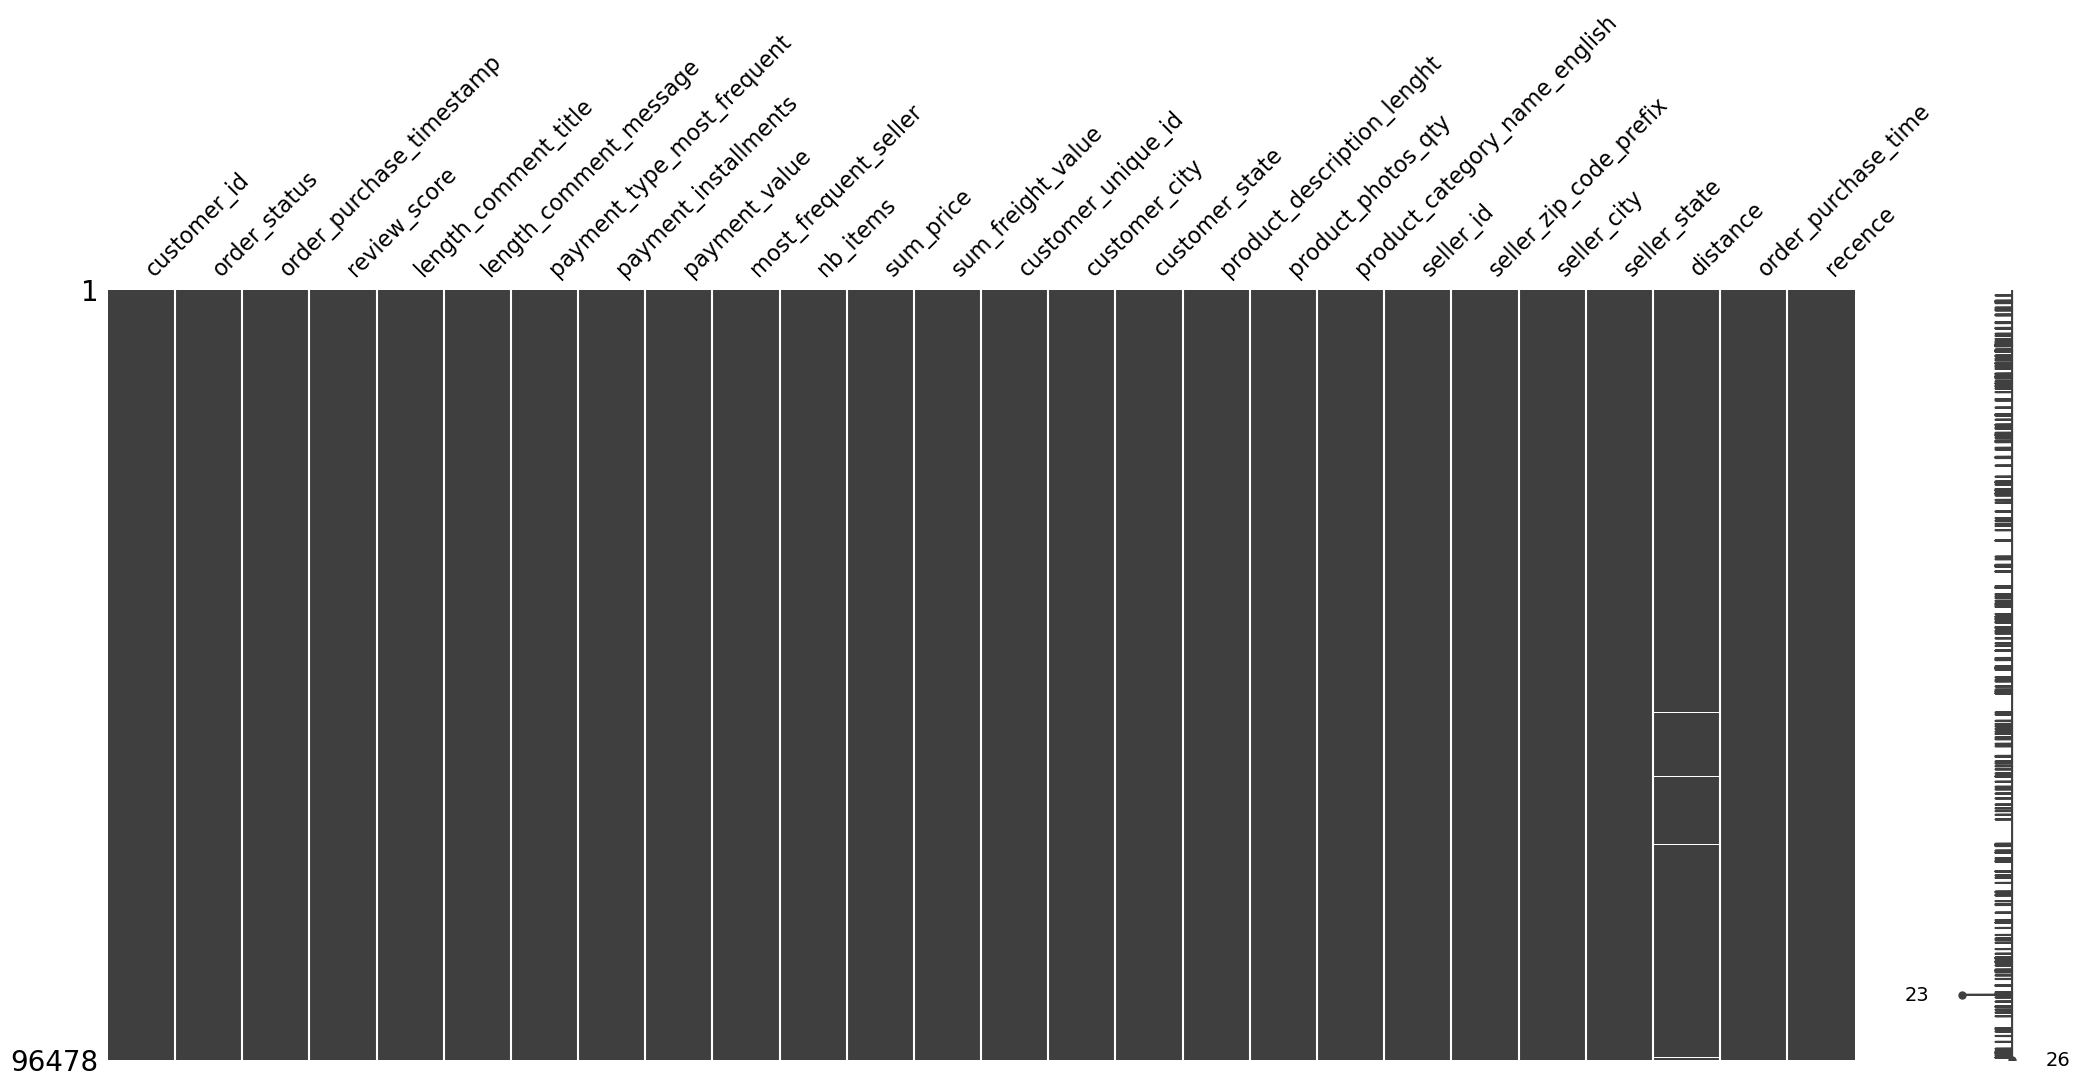

In [ ]:
import missingno as msno

msno.matrix(df_merge)

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 96477
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96478 non-null  object        
 1   order_status                   96478 non-null  object        
 2   order_purchase_timestamp       96478 non-null  datetime64[ns]
 3   review_score                   96478 non-null  float64       
 4   length_comment_title           96478 non-null  float64       
 5   length_comment_message         96478 non-null  float64       
 6   payment_type_most_frequent     96477 non-null  object        
 7   payment_installments           96477 non-null  float64       
 8   payment_value                  96477 non-null  float64       
 9   most_frequent_seller           96478 non-null  object        
 10  nb_items                       96478 non-null  float64       
 11  sum_price      

In [ ]:
df_merge[df_merge["payment_type_most_frequent"].isnull()]

,customer_id,order_status,order_purchase_timestamp,review_score,length_comment_title,length_comment_message,payment_type_most_frequent,payment_installments,payment_value,most_frequent_seller,nb_items,sum_price,sum_freight_value,customer_unique_id,customer_city,customer_state,product_description_lenght,product_photos_qty,product_category_name_english,seller_id,seller_zip_code_prefix,seller_city,seller_state,distance,order_purchase_time,recence
88316,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,1.0,0.0,46.0,NaN,NaN,NaN,ecccfa2bb93b34a3bf033cc5d1dcdc69,3.0,134.97,8.49,830d5b7aaa3b6f1e9ad63703bec97d23,sao joaquim da barra,SP,1036.0,1.0,Health_and_Beauty,ecccfa2bb93b34a3bf033cc5d1dcdc69,81810.0,curitiba,PR,5.120661,09/15/2016,767.0


In [ ]:
df_merge.dropna(inplace=True)

In [ ]:
list_sum = ["nb_items","payment_value"]
list_count =["customer_id"]
list_mod = ["payment_type_most_frequent","product_category_name_english"]
list_mean = ["review_score","payment_installments","length_comment_title","length_comment_message"]
list_first = ["recence"]
list_median = ["product_photos_qty","product_description_lenght"]

dict_sum = dict.fromkeys(list_sum,"sum")
dict__count = dict.fromkeys(list_count,"count")
dict_mod = dict.fromkeys(list_mod,get_mode)
dict_mean = dict.fromkeys(list_mean,"mean")
dict_first = dict.fromkeys(list_first,"first")
dict_median =dict.fromkeys(list_median,np.median)

dict_agg = {**dict_sum ,**dict__count,**dict_mod,**dict_mean,**dict_first,**dict_median}

In [ ]:
df_final = df_merge.groupby("customer_unique_id").agg(dict_agg)

In [ ]:
df_final.columns 

Index(['nb_items', 'payment_value', 'customer_id',
       'payment_type_most_frequent', 'product_category_name_english',
       'review_score', 'payment_installments', 'length_comment_title',
       'length_comment_message', 'recence', 'product_photos_qty',
       'product_description_lenght'],
      dtype='object')

In [ ]:
df_final.columns = ["nb_items_total","montant_total","nb_commande","payment_type_most_frequent","most_frequent_product_category","mean_review_score","mean_payment_installments","mean_length_comment_title","mean_length_comment_message","recence","med_product_photos_qty","med_product_description_lenght"]

In [ ]:
df_final.to_csv("data/data_merge.csv",index=False)